This notebook tries to learn harmonic functions via pytorch_lightning.

## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import dataclasses
import logging
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
sys.path.append("..")

from src.experiments.harmonics.run_experiment import ExperimentConfig
from src.experiments.harmonics.fc_net import FCNet, FCNetConfig
from src.experiments.harmonics.harmonics import (
    HarmonicDataModule,
    HarmonicFn,
    HarmonicFnTrainable,
    HarmonicFnConfig,
)
import src.utils as utils

## Set up ground truth function

In [ ]:
def visualize(
    model: nn.Module,
    pad: tuple[int, int] = (1, 5),
    value: float = 0.5
):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    with torch.no_grad():
        img = utils.to_2d_image(
            lambda xs: model(F.pad(input=xs, pad=pad, mode="constant", value=value)),
            side_samples=512
        ).numpy()
    plt.imshow(img, origin="lower")
    plt.subplot(1, 2, 2)
    plt.hist(img.flatten(), bins=128)

In [ ]:
cfg = ExperimentConfig(
    input_dim=4,
    freq_limit=2,
    num_components=4,
    learning_rate=3e-4,
    layer_widths=(128, 128, 128, 1),#, 1024, 1024, 1),
    batch_size=256,
    early_stopping_monitor="val_mse",
    early_stopping_patience=64,
    max_epochs=100,
)
print(cfg)

hf = HarmonicFn(
    cfg=HarmonicFnConfig(
        input_dim=cfg.input_dim,
        freq_limit=cfg.freq_limit,
        num_components=cfg.num_components,
        seed=-1,
    )
)
visualize(hf, pad=(1,1), value=0.2)

# Learning

#### Utility code

In [ ]:
def get_mse(
    model: pl.LightningModule,
    dl: torch.utils.data.DataLoader,
):
    return pl.Trainer(
        enable_progress_bar=False,
    ).test(
        model=model,
        dataloaders=dm.val_dataloader(),
        verbose=False,
    )[0]['test_mse']

class TrainHistory(pl.Callback):
    def __init__(self, print_every: int):
        self.print_every = print_every
        self.epoch_idx = 0
        self.metric_list = []

    def on_train_epoch_end(self, trainer: pl.Trainer, *_, **__):
        float_metrics = {
            k: float(v) for k, v in trainer.logged_metrics.items()
        }
        self.metric_list.append(float_metrics)
        
        if self.epoch_idx % self.print_every == 0:
            print(
                f"epoch: {self.epoch_idx:04}; "
                f"train_mse: {float_metrics['train_mse']:.6f}; "
              + f"val_mse: {float_metrics['val_mse']:.6f}"
            )
        
        self.epoch_idx += 1
        
def train(
    model: pl.LightningModule,
    n_train: int,
    cfg: ExperimentConfig,
    max_epochs: int = 500,
    patience: int = 100,
    print_every: int = 50,
):
    dm = HarmonicDataModule(
        hf=hf,
        n_train=n_train,
        n_val=cfg.n_val,
        train_seed=42,
        val_seed=cfg.val_seed,
        num_workers=cfg.num_workers,
        batch_size=cfg.batch_size,
    )
    
    th = TrainHistory(print_every=print_every)
    trainer = pl.Trainer(
        gpus=1,
        deterministic=True,
        enable_checkpointing=False,
        logger=False,  # We do custom logging instead.
        log_every_n_steps=1,
        max_epochs=max_epochs,
        callbacks=[
            EarlyStopping(
                monitor=cfg.early_stopping_monitor,
                patience=patience,
                mode="min",
            ),
            th
        ],
        enable_progress_bar=False,
        weights_summary=None,
    )
    
    trainer.fit(
        model=model,
        datamodule=dm,
    )
    
    return th

In [ ]:
def single_exp(
    model: pl.LightningModule,
    n_train: int,
    cfg: ExperimentConfig,
):
    visualize(hf, pad=(1,1), value=0.2)
    visualize(model, pad=(1,1), value=0.2)

    th = train(
        model=model,
        cfg=cfg,
        n_train=n_train,
    )

    visualize(model, pad=(1,1), value=0.2)

    df = pd.DataFrame(th.metric_list)
    plt.figure(dpi=100);
    df.plot(ax=plt.gca(), alpha=0.5);
    df.rolling(20).mean().plot(ax=plt.gca());
    plt.yscale('log')
    
    return df

## Classical reconstruction techniques

The setup is as follows.
We have a periodic function $f: [0, 1)^d \to \mathbb{R}$.

We wish to learn this function from samples
$(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)$
where $y_i = f(\mathbf{x}_i)$.

To do this, we will pick some set of
orthonormal basis functions $\{\phi_j \,|\, j \in J\}$
and attempt to approximate $f$ as

$$
\hat{f} = \sum_{j} a_j \, \phi_j.
$$

In other words, $\hat{f}$ is parameterized by the vector
$\mathbf{a} \in \mathbb{R}^J$.

To learn $\mathbf{a}$, we will solve the optimization problem

$$
\begin{aligned}
\min_{\mathbf{a}} \quad & \| \hat{f} \|^2 \\
\textrm{s.t.} \quad & \hat{f}(\mathbf{x}_i) = y_i, \qquad i = 1, \ldots, n.
\end{aligned}
$$

Since $\{\phi_j \,|\, j \in J\}$ is orthonormal,
this is equivalent to solving the optimization problem

$$
\begin{aligned}
\min_{\mathbf{a}} \quad & \| \hat{a} \|^2 \\
\textrm{s.t.} \quad & \mathbf{\Phi}\, \mathbf{a} = \mathbf{y},
\end{aligned}
$$

where $\mathbf{\Phi} \in \mathbb{R}^{n \times J}$
with $\mathbf{\Phi}_{ij} = \phi_j(x_i)$
and $\mathbf{y} \in \mathbb{R}^{n}$
with $\mathbf{y}_i = y_i$.

This can be solved by calling `numpy.linalg.lstsq`,
which has complexity

$$O(J \times n \times \min(J, n)),$$

per https://stackoverflow.com/a/11570417/1337463.

If we use as our basis set all integer frequency
sine and cosine functions with bandlimit $B$,
then the complexity of this reconstruction method is

$$O(\min((B+1)^{2d} n,\, (B+1)^d n^2)).$$

In [ ]:
dm = HarmonicDataModule(
    hf=hf,
    n_train=512,
    n_val=cfg.n_val,
    train_seed=42,
    val_seed=cfg.val_seed,
    num_workers=cfg.num_workers,
    batch_size=cfg.batch_size,
)
dm.setup()

hf_hat = HarmonicFn.construct_via_lstsq(
    xs=dm.train_ds.tensors[0].numpy(),
    ys=dm.train_ds.tensors[1].numpy() + 0.1 * np.random.normal(size=512),
    bandlimit=2,
    coeff_threshold=1e-6,
    lamb=1e-3,
)

visualize(hf, pad=(1,1), value=0.2)
visualize(hf_hat, pad=(1,1), value=0.2)

hf_mse = get_mse(model=hf, dl=dm.val_dataloader())
hf_hat_mse = get_mse(model=hf_hat, dl=dm.val_dataloader())
print(f"{hf_mse     = }")
print(f"{hf_hat_mse = }")

In [16]:
%%time
n_trains = np.array([1, 2, 4, 8, 16, 32] + list(range(50, 400)) + [512, 1024, 2048, 5096], dtype=np.int64)
results = []
for n_train in tqdm(n_trains):
    mses = []
    for trial_idx in range(1): # trials
        dm = HarmonicDataModule(
            hf=hf,
            n_train=n_train,
            n_val=cfg.n_val,
            train_seed=trial_idx,
            val_seed=cfg.val_seed,
            num_workers=cfg.num_workers,
            batch_size=cfg.batch_size,
        )
        dm.setup()

        hf_hat = HarmonicFn.construct_via_lstsq(
            xs=dm.train_ds.tensors[0].numpy(),
            ys=dm.train_ds.tensors[1].numpy(),
            bandlimit=2,
            coeff_threshold=1e-6,
            lamb=1e-9,
        )

        mse = get_mse(model=hf_hat, dl=dm.val_dataloader())
        mses.append(mse)
    results.append(mses)
    
results = np.array(results)

100%|██████████| 360/360 [01:10<00:00,  5.09it/s]

CPU times: user 16min 44s, sys: 32min 26s, total: 49min 10s
Wall time: 1min 10s


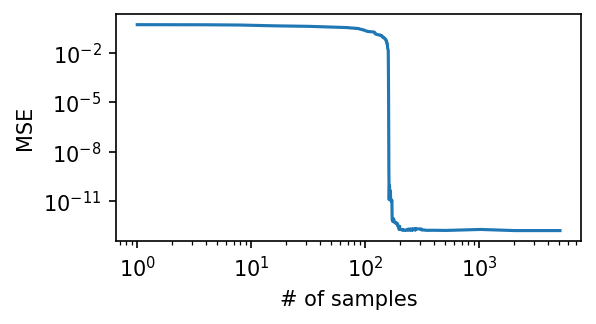

In [17]:
plt.figure(dpi=150, figsize=(4, 2))
plt.plot(n_trains, results.min(axis=-1))
plt.yscale('log'); plt.xscale('log');
plt.ylabel("MSE"); plt.xlabel("# of samples");

## Train neural network

epoch: 0000; train_mse: 0.533326; val_mse: 1.898913
epoch: 0050; train_mse: 0.298133; val_mse: 0.457350
epoch: 0100; train_mse: 0.112189; val_mse: 0.283686
epoch: 0150; train_mse: 0.084905; val_mse: 0.280296
epoch: 0200; train_mse: 0.224121; val_mse: 0.271360
epoch: 0250; train_mse: 0.028463; val_mse: 0.246302
epoch: 0300; train_mse: 0.018561; val_mse: 0.241641
epoch: 0350; train_mse: 0.013863; val_mse: 0.233016
epoch: 0400; train_mse: 0.009503; val_mse: 0.232514
epoch: 0450; train_mse: 0.007471; val_mse: 0.227546


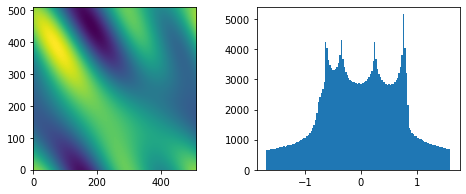

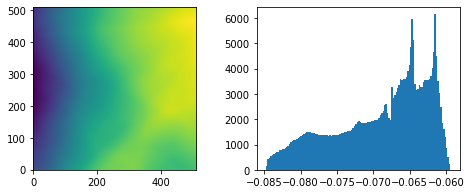

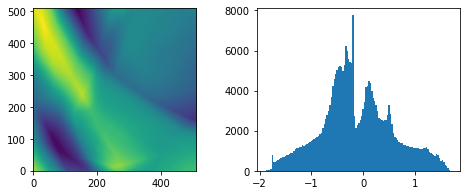

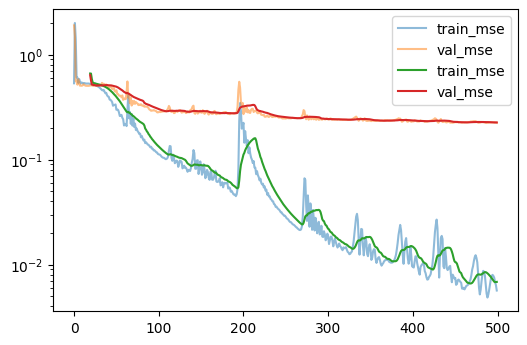

In [11]:
df = single_exp(
    model=FCNet(
        FCNetConfig(
            input_dim=cfg.input_dim,
            layer_widths=(128, 128, 128, 1),
            learning_rate=3e-2,
        )
    ),
    n_train=256,
    cfg=cfg,
)

epoch: 0000; train_mse: 0.443823; val_mse: 0.639980
epoch: 0050; train_mse: 0.229387; val_mse: 0.244630
epoch: 0100; train_mse: 0.117721; val_mse: 0.123582
epoch: 0150; train_mse: 0.062655; val_mse: 0.082899
epoch: 0200; train_mse: 0.056453; val_mse: 0.077299
epoch: 0250; train_mse: 0.037682; val_mse: 0.066723
epoch: 0300; train_mse: 0.049275; val_mse: 0.062394
epoch: 0350; train_mse: 0.048906; val_mse: 0.045170
epoch: 0400; train_mse: 0.034587; val_mse: 0.043997
epoch: 0450; train_mse: 0.024712; val_mse: 0.050186


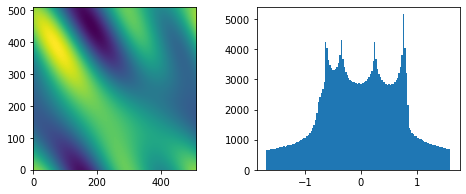

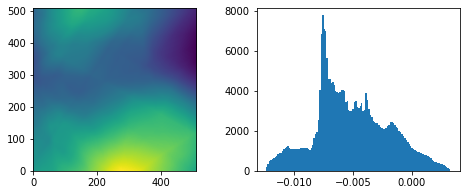

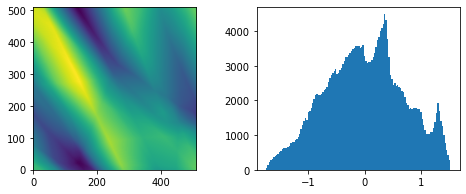

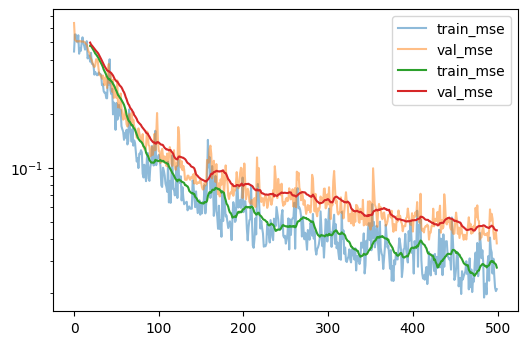

In [12]:
df = single_exp(
    model=FCNet(
        FCNetConfig(
            input_dim=cfg.input_dim,
            layer_widths=(128, 128, 128, 1),
            learning_rate=3e-2,
        )
    ),
    n_train=1024,
    cfg=cfg,
)

## Train harmonic params

epoch: 0000; train_mse: 1.301095; val_mse: 1.027026
epoch: 0050; train_mse: 0.013446; val_mse: 0.280838
epoch: 0100; train_mse: 0.001130; val_mse: 0.192933
epoch: 0150; train_mse: 0.000341; val_mse: 0.178181
epoch: 0200; train_mse: 0.000148; val_mse: 0.173314
epoch: 0250; train_mse: 0.000071; val_mse: 0.170412
epoch: 0300; train_mse: 0.000037; val_mse: 0.168339
epoch: 0350; train_mse: 0.000020; val_mse: 0.166838
epoch: 0400; train_mse: 0.000012; val_mse: 0.165759
epoch: 0450; train_mse: 0.000007; val_mse: 0.164984


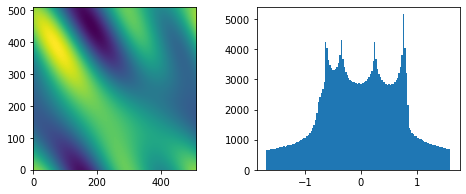

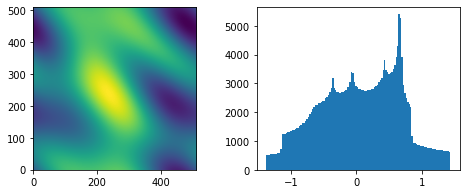

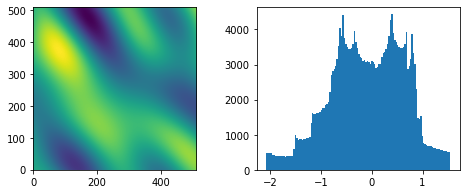

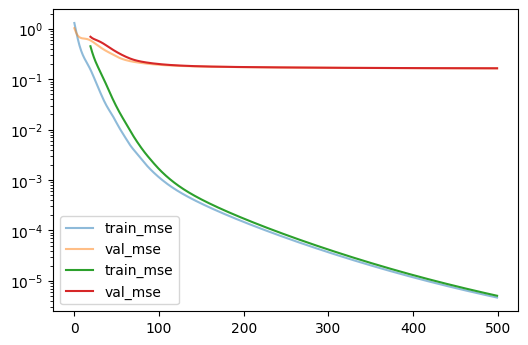

In [13]:
pl.seed_everything(42)
df = single_exp(
    model=HarmonicFnTrainable(
        cfg=HarmonicFnConfig(
            input_dim=cfg.input_dim,
            freq_limit=cfg.freq_limit,
            num_components=100 * cfg.num_components,
            seed=42,
            learning_rate=3e-3
        )
    ),
    n_train=256,
    cfg=cfg,
)

epoch: 0000; train_mse: 0.765196; val_mse: 0.781205
epoch: 0050; train_mse: 0.001813; val_mse: 0.006080
epoch: 0100; train_mse: 0.000715; val_mse: 0.003589
epoch: 0150; train_mse: 0.000440; val_mse: 0.002522
epoch: 0200; train_mse: 0.000291; val_mse: 0.001939
epoch: 0250; train_mse: 0.000189; val_mse: 0.001554
epoch: 0300; train_mse: 0.000167; val_mse: 0.001285
epoch: 0350; train_mse: 0.000143; val_mse: 0.001066
epoch: 0400; train_mse: 0.000112; val_mse: 0.000918
epoch: 0450; train_mse: 0.000106; val_mse: 0.000773


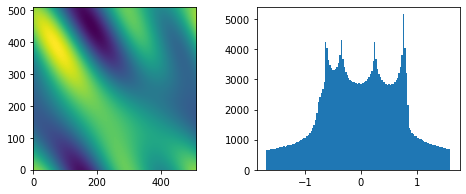

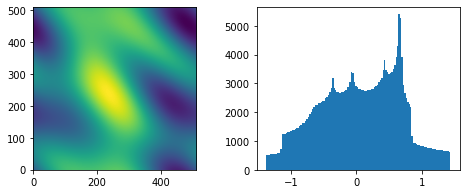

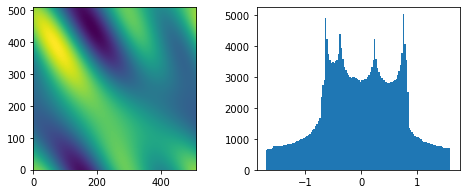

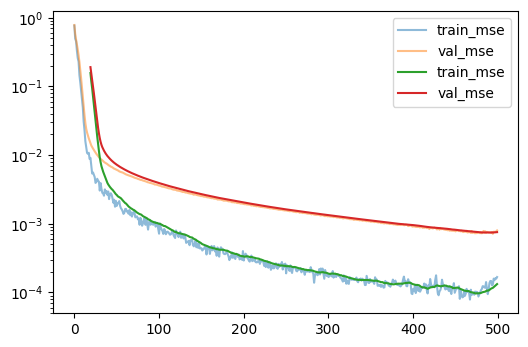

In [14]:
pl.seed_everything(42)
df = single_exp(
    model=HarmonicFnTrainable(
        cfg=HarmonicFnConfig(
            input_dim=cfg.input_dim,
            freq_limit=cfg.freq_limit,
            num_components=100 * cfg.num_components,
            seed=42,
            learning_rate=3e-3
        )
    ),
    n_train=1024,
    cfg=cfg,
)

epoch: 0000; train_mse: 0.785491; val_mse: 0.939469
epoch: 0050; train_mse: 0.068608; val_mse: 0.625956
epoch: 0100; train_mse: 0.017362; val_mse: 0.665252


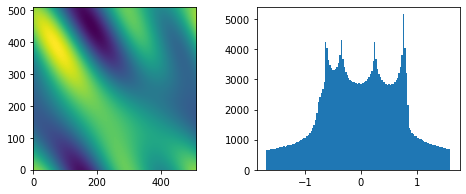

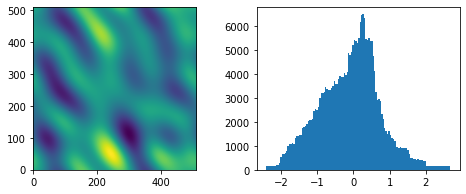

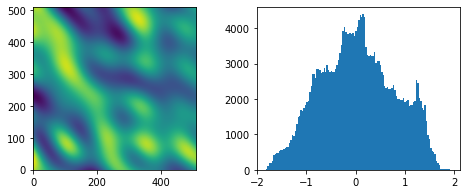

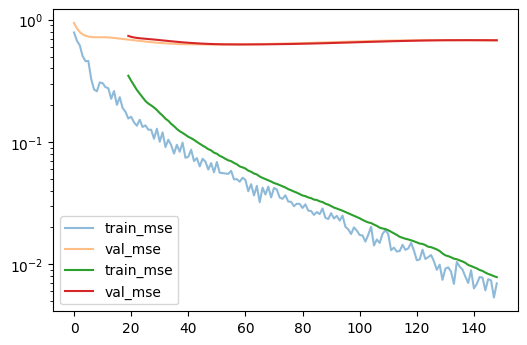

In [15]:
pl.seed_everything(42)
df = single_exp(
    model=HarmonicFnTrainable(
        cfg=HarmonicFnConfig(
            input_dim=cfg.input_dim,
            freq_limit=2 * cfg.freq_limit,
            num_components=100 * cfg.num_components,
            seed=42,
            learning_rate=3e-3
        )
    ),
    n_train=1024,
    cfg=cfg,
)